In [2]:
import sys
path = "../"
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    path = "./drive/MyDrive/566 Project"
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
%%capture
!pip install transformers datasets

In [4]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, ViTForImageClassification
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl 
import torch.nn.functional as F

## Legacy Code

In [4]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224") 
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224") 

In [33]:
raw_data = open(path+f"data/adv_test_cropped_name", 'rb')
data1 = pkl.load(raw_data)
raw_data = open(path+f"data/test2_cropped_name", 'rb')
data2 = pkl.load(raw_data)
unprocessed_data = data1+data2

In [34]:
# unprocessed_data[0][1].shape, data[0][1].pixel_values.shape, 
print(unprocessed_data[0][1].shape, len(unprocessed_data))

(224, 224, 3) 8993


In [7]:
data = []

for i in range(len(unprocessed_data)):
  name, n, c = unprocessed_data[i]
  if len(c.shape) == 3:# and len(n.shape) == 3: 
    # n = image_processor(images=n, return_tensors="pt")
    c = image_processor(images=c, return_tensors="pt")
    data.append([name, c])

print(len(data))

13685


In [31]:
len(unprocessed_data)

8993

In [30]:
#For RAM constraints
FILES_TO_READ = min(14_000, len(unprocessed_data))

data = []
label_map = pd.read_csv(path+"data/labels.csv", dtype={'0': 'string', '1':'string'}, names=['folder', 'label'], header=None, skiprows=1)
label_map['folder'] = label_map['folder'].str[1:]
failed_label = []

for i in tqdm(range(FILES_TO_READ)):
  folder_num, n, c = unprocessed_data[i]
  if len(c.shape) == 3: # and len(c.shape) == 3:
    label_id = folder_num.split("_n")[1]
    try:
        l = label_map.query("folder == @label_id").values[0][1]
        c = image_processor(images=c, return_tensors="pt")
        data.append([l,c])
    except:
      l = None
      failed_label.append(label_id) 

    # n = image_processor(images=n, return_tensors="pt")
  # if i%500 == 0:
  #   print("Files finised",i)

print("\nAll data was processed ")
print(f"Missing labels = {len(failed_label)}")
print(f"Processed Data {len(data)}")

100%|██████████| 8993/8993 [00:26<00:00, 345.35it/s]


All data was processed 
Missing labels = 0
Processed Data 8817


In [8]:
class DS(Dataset):
    def __init__(self, data):
        super(Dataset, self).__init__()
        self.data = data
        
    def __len__(self):
        return len(data)
        
    def __getitem__(self, index):
        # print(self.__len__() , index)
        assert self.__len__() > index
        return self.data[index][0], self.data[index][1], self.data[index][2]   #returning label, noise_img

In [13]:
def get_data(pass_no=1, masking_ratio=50):
    print(f"Loading data: Masking ratio: {masking_ratio}, Pass_no: {pass_no}")
    raw_data = open(path+f"data/recon_noise_{pass_no}_image_denorm_{masking_ratio}.pkl", 'rb')
    data = pkl.load(raw_data)
    return data

def get_labels(masking_ratio=50):
    print(f"Loading labels: Masking ratio: {masking_ratio}")
    raw_data = open(path+f"data/recon_noise_labels_denorm_{masking_ratio}.pkl", 'rb')
    labels = pkl.load(raw_data)
    return labels

def get_paired_data(labels, data):
    unprocessed_data = []
    for l, img in zip(labels, data):
        unprocessed_data.append([l,img])
    print(f"Length of data: {len(unprocessed_data)}")
    return unprocessed_data

In [34]:
def process_data(labels, data):
    unprocessed_data = []
    for l, img in zip(labels, data):
        unprocessed_data.append([l,img])
    print(f"Length of data: {len(unprocessed_data)}")
    
    #For RAM constraints
    FILES_TO_READ = min(14_000, len(unprocessed_data))

    data = []
    label_map = pd.read_csv(path+"data/labels.csv", dtype={'0': 'string', '1':'string'}, names=['folder', 'label'], header=None, skiprows=1)
    label_map['folder'] = label_map['folder'].str[1:]
    failed_label = []

    for i in tqdm(range(FILES_TO_READ)):
      folder_num, n = unprocessed_data[i]
      if len(n.shape) == 3:
        label_id = folder_num.split("_n")[1]
        try:
          l = label_map.query("folder == @label_id").values[0][1]
        except:
          l = None
          failed_label.append(label_id) 
        #l = folder_num
        n = image_processor(images=n, return_tensors="pt")
        data.append([l,n])


    print("\nAll data was processed. Missing labels = {len(failed_label)}, Processed Data {len(data)}")
    return data

In [9]:
imagenet_std = torch.tensor(image_processor.image_std)
imagenet_mean = torch.tensor(image_processor.image_mean)

def show_image(image, title='', is_numpy=False):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    if is_numpy:
        plt.imshow(torch.from_numpy(image))
    else:
        plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

In [10]:
trial = torch.einsum('chw->hwc', data[21][1].pixel_values.view(3,224,224))
show_image(trial, data[21][0])

IndexError: list index out of range

In [37]:
class DS(Dataset):
     def __init__(self, data):
         super(Dataset, self).__init__()
         self.data = data
        
     def __len__(self):
         return len(data)
        
     def __getitem__(self, index):
        # print(self.__len__() , index)
        assert self.__len__() > index
        return self.data[index][0], self.data[index][1]   #returning label, noise_img

In [38]:
def get_predictions(dataloader, model):
    predicted_labels = []
    true_labels = []

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Currently using {device}")

    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (labels, noise_inputs) in enumerate(tqdm(dataloader)):
            inputs = noise_inputs.pixel_values.reshape(-1,3,224,224).to(device)
            output = model(inputs)
            logits = output.logits
            logits = logits.detach().cpu()
            predicted_class_idx = logits.argmax(-1)
            for idx in predicted_class_idx:
                predicted_labels.append(model.config.id2label[idx.item()])
            true_labels.extend(labels)
    
    return predicted_labels, true_labels

In [39]:
def string_accuracy(pred, truth):
    if len(pred) != len(truth):
        return 0.0

    correct = sum([1 if pred[i] == truth[i] else 0 for i in range(len(pred))])
    return float(correct) / len(pred)

In [40]:
# for our dataset
raw_data = get_data(pass_no=1, masking_ratio=75)
labels = get_labels(masking_ratio=75)
data = process_data(labels, raw_data)
ds = DS(data)
test_dataloader = DataLoader(ds, batch_size=16, shuffle=True)
predicted_labels, true_labels = get_predictions(test_dataloader, model)
acc = string_accuracy(predicted_labels, true_labels)
print(acc)

Loading data: Masking ratio: 75, Pass_no: 1
Loading labels: Masking ratio: 75
Length of data: 8817


100%|██████████| 8817/8817 [00:39<00:00, 225.52it/s]



All data was processed. Missing labels = {len(failed_label)}, Processed Data {len(data)}
Currently using cuda


100%|██████████| 552/552 [01:32<00:00,  5.99it/s]

0.33991153453555634


## Stats

| Model | Input | Mask | Accuracy |
| -- | --| -- | -- |
| - | Clean | - | 81.81 |
| Base MAE | Clean, Recon | 75 | 31.66 |
| Finetune MAE | Clean, Recon + visible | 75 | 41.91 |
| Finetune MAE | Clean, Recon + visible | 50 | 66.29 |
| - | Noise | - | 76.89 |
| Finetune MAE | Noise, Recon | 75 | 31.63 |
| Finetune MAE | Noise, Recon + visible | 75 | 28.89 |
| Finetune MAE | Noise, Recon + visible | 50 | 48.46 |
| Finetune MAE | Noise, Recon + visible | 50 | 35.32 (2 pass) |
| Finetune MAE | Noise, Recon + visible | 25 | 65.12  |
| Finetune MAE | Noise, Recon + visible | 25 | 54.09 (2 pass) |
| Finetune MAE | Noise, Recon + visible | 10 | 73.42 |
| Finetune MAE | Noise, Recon + visible | 10 | 68.66 (2 pass) |
| Finetune MAE | Noise, Recon + visible | 5 | 75.59 |
| Finetune MAE | Noise, Recon + visible | 5 | 73.29 (2 pass) |

# Refactored Code

In [5]:
def read_data(input_data, pass_no, finetune, masking_ratio, recon_and_vis):
    reconstruc_f = "recon_vis" if recon_and_vis else "recon"
    # print(f"Reading {input_data} data with {reconstruc_f} ")
    # print("Pass is", pass_no)
    # print(f"Data reconstructed on {finetune} model and {masking_ratio} masking")
    print("Reading file: "+path+f"data/{input_data}_{reconstruc_f}_pass_{pass_no}_image_{finetune}_{int(masking_ratio*100)}.pkl\n")
    raw_data = open(path+f"data/{input_data}_{reconstruc_f}_pass_{pass_no}_image_{finetune}_{int(masking_ratio*100)}.pkl", 'rb')
    data = pkl.load(raw_data)
    return data

def read_labels(input_data, finetune, masking_ratio, recon_and_vis):
    reconstruc_f = "recon_vis" if recon_and_vis else "recon"
    # print(f"Reading {input_data} labels with {reconstruc_f} ")
    # print(f"Data reconstructed on {finetune} model and {masking_ratio} masking")
    print("Reading file: "+path+f"data/{input_data}_{reconstruc_f}_labels_image_{finetune}_{int(masking_ratio*100)}.pkl\n")
    raw_data = open(path+f"data/{input_data}_{reconstruc_f}_labels_image_{finetune}_{int(masking_ratio*100)}.pkl", 'rb')
    labels = pkl.load(raw_data)
    return labels

In [6]:
def process_data(labels, data, is_fgsm=False):
    unprocessed_data = []
    for l, img in zip(labels, data):
        unprocessed_data.append([l,img])
    print(f"Length of data: {len(unprocessed_data)}")
    
    FILES_TO_READ = min(14_000, len(unprocessed_data))

    data = []
    label_map = pd.read_csv(path+"data/labels.csv", dtype={'0': 'string', '1':'string'}, names=['folder', 'label'], header=None, skiprows=1)
    label_map['folder'] = label_map['folder'].str[1:]
    failed_label = []
    
    print("Processing Data...")

    for i in tqdm(range(FILES_TO_READ)):
        folder_num, n = unprocessed_data[i]
        if len(n.shape) == 3:
            if is_fgsm:
                label_id = folder_num
            else:
                label_id = folder_num.split("_n")[1]
        try:
            if is_fgsm:
                l = folder_num
            else:
                l = label_map.query("folder == @label_id").values[0][1]
        except:
            l = None
            failed_label.append(label_id) 
        n = image_processor(images=n, return_tensors="pt")
        data.append([l,n])

    print(f"\nAll data was processed. Missing labels = {len(failed_label)}, Processed Data {len(data)}")
    return data

In [7]:
def show_image(image, title='', is_numpy=False):
    # image is [H, W, 3]
    imagenet_std = torch.tensor(image_processor.image_std)
    imagenet_mean = torch.tensor(image_processor.image_mean)
    assert image.shape[2] == 3
    if is_numpy:
        plt.imshow(torch.from_numpy(image))
    else:
        plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

In [8]:
class DS(Dataset):
    def __init__(self, data):
        super(Dataset, self).__init__()
        self.data = data
        
    def __len__(self):
        return len(data)
        
    def __getitem__(self, index):
        # print(self.__len__() , index)
        assert self.__len__() > index
        return self.data[index][0], self.data[index][1]   #returning label, noise_img

In [9]:
def get_predictions(dataloader, model):
    predicted_labels = []
    true_labels = []

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f"Currently using {device}")

    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (labels, noise_inputs) in enumerate(tqdm(dataloader)):
            inputs = noise_inputs.pixel_values.reshape(-1,3,224,224).to(device)
            output = model(inputs)
            logits = output.logits
            logits = logits.detach().cpu()
            predicted_class_idx = logits.argmax(-1)
            for idx in predicted_class_idx:
                predicted_labels.append(model.config.id2label[idx.item()])
            true_labels.extend(labels)
    
    return predicted_labels, true_labels

In [10]:
def string_accuracy(pred, truth):
    if len(pred) != len(truth):
        return 0.0

    correct = sum([1 if pred[i] == truth[i] else 0 for i in range(len(pred))])
    return float(correct) / len(pred)

In [11]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224") 
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224") 

In [17]:
INPUT_DATA = "noise"   #["noise", "clean"]
RECON_AND_VIS = False
FINETUNE = "gaussian_noise"      #["None", "gaussian_noise", "fgsm"]
MASKING_RATIO = 0.50   #[0.75, 0.5, 0.2]
is_fgsm = False
PASS_NO = "2"          #["1", "2"]

print("Reading pass-",PASS_NO)

img_data_pass_1 = read_data(input_data=INPUT_DATA, 
                            pass_no = PASS_NO, 
                            finetune=FINETUNE, 
                            masking_ratio=MASKING_RATIO,
                            recon_and_vis = RECON_AND_VIS)

labels = read_labels(input_data=INPUT_DATA, 
                    finetune=FINETUNE,
                    masking_ratio=MASKING_RATIO,
                    recon_and_vis = RECON_AND_VIS)

data = process_data(labels, img_data_pass_1, is_fgsm)

ds = DS(data)
test_dataloader = DataLoader(ds, batch_size=16, shuffle=True)

print("Predicting labels")
predicted_labels, true_labels = get_predictions(test_dataloader, model)

acc = string_accuracy(predicted_labels, true_labels)

model_type = "baseline" if FINETUNE=="None" else FINETUNE
file_type = "recon and vis" if RECON_AND_VIS else "recon"

print(f"Accuracy is:{acc} on {model_type} model with masking ratio {MASKING_RATIO}")

print(f"Model: {model_type}")
print(f"Input: {INPUT_DATA} with {file_type}")
print(f"Masking: {MASKING_RATIO}")
print(f"Accuracy: {acc}")

Reading pass- 2
Reading file: ../data/noise_recon_pass_2_image_gaussian_noise_50.pkl

Reading file: ../data/noise_recon_labels_image_gaussian_noise_50.pkl

Length of data: 8817
Processing Data...


100%|██████████| 8817/8817 [00:50<00:00, 174.26it/s]



All data was processed. Missing labels = 0, Processed Data 8817
Predicting labels
Currently using cuda


100%|██████████| 552/552 [01:50<00:00,  4.99it/s]

Accuracy is:0.226267437904049 on gaussian_noise model with masking ratio 0.5
Model: gaussian_noise
Input: noise with recon
Masking: 0.5
Accuracy: 0.226267437904049


| Model | Input | Mask | Accuracy |
| -- | --| -- | -- |
|Baseline|clean, recon and vis|0.75|51.65
|Baseline|clean, recon |0.75|43.74
|Baseline|noise, recon and vis|0.75|31.48
|Baseline|noise, recon |0.75|33.76
|Finetune(gaussian)|clean, recon and vis|0.75|41.65
|Finetune(gaussian)|clean, recon|0.75|31.41
|Finetune(gaussian)|noise, recon and vis|0.75|28.18
|Finetune(gaussian)|noise, recon|0.75|31.47
|Finetune(gaussian)|noise, recon and vis, pass 2|0.75|14.25
|Finetune(gaussian)|noise, recon, pass 2|0.75|10.35
| -- | --| -- | -- |
|Baseline|clean, recon and vis|0.50|66.56
|Baseline|clean, recon|0.50|58.12
|Baseline|noise, recon and vis|0.50|48.31
|Baseline|noise, recon|0.50|51.76
|Baseline|noise, recon and vis, pass 2|0.50|34.31
|Baseline|noise, recon, pass 2|0.50|30.88
|Finetune(gaussian)|clean, recon and vis|0.50|66.26
|Finetune(gaussian)|clean, recon|0.50|45.82
|Finetune(gaussian)|noise, recon and vis|0.50|48.50
|Finetune(gaussian)|noise, recon|0.50|46.19
|Finetune(gaussian)|noise, recon and vis, pass 2|0.50|34.96
|Finetune(gaussian)|noise, recon, pass 2|0.50|22.62
| -- | --| -- | -- |
|Baseline|fgsm noise, recon and vis|0.75|2.67
|Baseline|fgsm noise, recon and vis, pass 2|0.75|1.47
|Baseline|fgsm clean, recon and vis|0.75|29.2
|Baseline|fgsm clean, recon and vis, pass 2|0.75|6.41
|Baseline|fgsm noise, recon|0.75|2.79
|Baseline|fgsm noise, recon, pass 2|0.75|0.09
|Baseline|fgsm clean, recon|0.75|11.5
|Baseline|fgsm clean, recon, pass 2|0.75|2.69
|Finetune(fgsm)|fgsm noise, recon and vis|0.75|9.72
|Finetune(fgsm)|fgsm noise, recon and vis, pass 2|0.75|3.86
|Finetune(fgsm)|fgsm clean, recon and vis|0.75|28.9
|Finetune(fgsm)|fgsm clean, recon and vis, pass 2|0.75|6.55
|Finetune(fgsm)|fgsm noise, recon|0.75|15.9
|Finetune(fgsm)|fgsm noise, recon, pass 2|0.75|2.81
|Finetune(fgsm)|fgsm clean, recon|0.75|12.29
|Finetune(fgsm)|fgsm clean, recon, pass 2|0.75|2.39
| -- | --| -- | -- |
|Baseline|fgsm noise, recon and vis|0.50|12.35
|Baseline|fgsm noise, recon and vis, pass 2|0.50|10.28
|Baseline|fgsm clean, recon and vis|0.50|69.15
|Baseline|fgsm clean, recon and vis, pass 2|0.50|34.7
|Baseline|fgsm noise, recon|0.50|25.52
|Baseline|fgsm noise, recon, pass 2|0.50|6.87
|Baseline|fgsm clean, recon|0.50|21.83
|Baseline|fgsm clean, recon, pass 2|0.50|7.17
|Finetune(fgsm)|fgsm noise, recon and vis|0.50|12.49
|Finetune(fgsm)|fgsm noise, recon and vis, pass 2|0.50|10.46
|Finetune(fgsm)|fgsm clean, recon and vis|0.50|68.53
|Finetune(fgsm)|fgsm clean, recon and vis, pass 2|0.50|35.16
|Finetune(fgsm)|fgsm noise, recon|0.50|26.36
|Finetune(fgsm)|fgsm noise, recon, pass 2|0.50|7.13
|Finetune(fgsm)|fgsm clean, recon|0.50|22.09
|Finetune(fgsm)|fgsm clean, recon, pass 2|0.50|7.02

Epsilon: 0.1	Test Accuracy = 2233 / 8817 = 0.25326074628558465

In [ ]:
# clean acc = 81% (directly clean image)
# recon clean acc(base MAE)(only reconstruction) = 31.66% XXXXX
# clean (finetune MAE)(recon + visible) = 41.91%   MASK = 75% 
# clean (finetune MAE)(recon + visible) = 66.29%   MASK = 50% 

# noise acc = 76.89%
# recons acc single pass(only reconstruction) = 31.63%
# noise(finetune)(renconstruction+visible) = 28.89%  MASK = 75% 
# noise(finetune)(reconstruction+visible) = 48.46%   MASK = 50%

# NOise --- first 50 and inverse 50


In [13]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [14]:
def test(model, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []
    
    print(f"Currently using {device}")

    model = model.to(device)
    model.eval()
    # Loop over all examples in test set
    for batch_idx, (labels, clean_inputs) in enumerate(tqdm(test_loader)):
        data, target = clean_inputs.pixel_values.reshape(-1,3,224,224), torch.tensor(model.config.label2id[labels[0]])
        # print(data, target)
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        logits = output.logits.squeeze(0)
        init_pred = logits.argmax(-1)
        # print(logits.squeeze(0).shape)
        # output = model(data)
        # init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(logits, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)
        logits = output.logits.squeeze(0)

        # Check for success
        final_pred = logits.argmax(-1) # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            # adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            # adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            adv_ex = [labels[0], perturbed_data.detach().cpu(), data.detach().cpu()]
            # print(adv_ex)
            adv_examples.append(adv_ex)
            # print(adv_examples)
        
        del data, target, perturbed_data, final_pred, init_pred, loss
            
        # show_image(torch.einsum('chw->hwc', data.detach().cpu().view(3,224,224)))
        # print(labels[0], model.config.id2label[init_pred.item()], model.config.id2label[final_pred.item()])

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [15]:
accuracies = []
examples = []
# epsilons = [0, .05, .1, .15, .2, .25, .3]
epsilons = [0.1]
device = "cuda"
ds = DS(data)
test_dataloader = DataLoader(ds, batch_size=1, shuffle=True)

# Run test for each epsilon
for eps in epsilons:    
    acc, ex = test(model, test_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Currently using cuda


100%|██████████| 8817/8817 [08:31<00:00, 17.24it/s]

Epsilon: 0.1	Test Accuracy = 2233 / 8817 = 0.25326074628558465


In [16]:
examples = examples[0]
label_cnt = {}
for e in examples:
    l = e[0]
    if l in label_cnt:
        label_cnt[l] += 1
    else:
        label_cnt[l] = 1

In [17]:
c = 0
for l in model.config.label2id.keys():
    if l not in label_cnt:
        c += 1
        # print(l)
c

696

In [18]:
denorm_data = []
# imagenet_mean = np.array(image_processor.image_mean)
# imagenet_std = np.array(image_processor.image_std)
for l, adv_img, clean_img in examples:
    denorm_data.append([l, torch.clip((torch.einsum('chw->hwc', adv_img.squeeze(0))* imagenet_std + imagenet_mean) * 255, 0, 255).int().numpy(), 
                       torch.clip((torch.einsum('chw->hwc', clean_img.squeeze(0))* imagenet_std + imagenet_mean) * 255, 0, 255).int().numpy()])
denorm_data[0]

['whistle',
 array([[[133, 150, 127],
         [127, 143, 127],
         [127, 127, 127],
         ...,
         [147, 164, 131],
         [147, 164, 156],
         [127, 162, 153]],
 
        [[127, 137, 127],
         [127, 142, 127],
         [127, 145, 127],
         ...,
         [148, 165, 131],
         [147, 164, 129],
         [127, 163, 153]],
 
        [[127, 127, 127],
         [127, 127, 127],
         [133, 132, 127],
         ...,
         [147, 164, 129],
         [146, 163, 128],
         [147, 164, 154]],
 
        ...,
 
        [[155, 174, 168],
         [153, 172, 166],
         [155, 172, 166],
         ...,
         [140, 157, 127],
         [127, 158, 150],
         [127, 158, 150]],
 
        [[154, 173, 166],
         [129, 148, 142],
         [156, 173, 167],
         ...,
         [127, 159, 127],
         [127, 136, 149],
         [127, 159, 151]],
 
        [[156, 173, 165],
         [156, 174, 166],
         [155, 172, 166],
         ...,
         [129, 1

In [19]:
fileObject = open(path+f"data/adv_test_cropped_name.pkl", 'wb')
pkl.dump(denorm_data, fileObject)
fileObject.close()

In [16]:
torch.cuda.empty_cache()

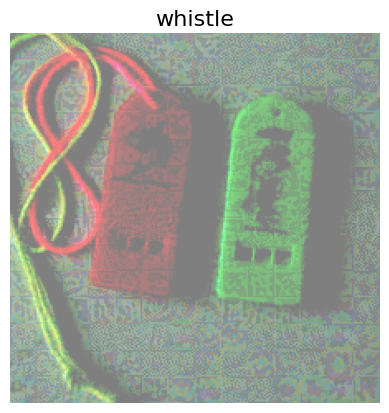

In [22]:
(true_label, img, true_img) = examples[0]
(true_label, img, true_img) = denorm_data[0]
# show_image(torch.einsum('chw->hwc', img.squeeze(0)), f"True: {true_label}")
show_image(img, true_label, is_numpy=True)

In [23]:
len(denorm_data)

4980

#

```
# This is formatted as code
```

# Dummy Code

## MAE

In [4]:

import transformers
from transformers import ViTMAEForPreTraining, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained('facebook/vit-mae-base')
model = ViTMAEForPreTraining.from_pretrained('facebook/vit-mae-base')

In [6]:
# match adversarial image (input) with clean image (target)

# had to split up pickle files for size

# data = [] # [[adv_0, clean_0], ..., [adv_k, clean_k]]
import pickle as pkl
data = open("./drive/MyDrive/566 Project/data/test1_cropped_name", 'rb')
data1 = pkl.load(data)
data = open("./drive/MyDrive/566 Project/data/test2_cropped_name", 'rb')
data2 = pkl.load(data)

unprocessed_data = (data1 + data2)
# unprocessed_data = data1

In [8]:
data = []
for i in range(len(unprocessed_data)):
  name, n,c = unprocessed_data[i]
  if len(n.shape) == 3 and len(c.shape) == 3: 
    n = image_processor(images=n, return_tensors="pt")
    c = image_processor(images=c, return_tensors="pt")
    data.append([name, n,c])


print(len(data))

8817


In [9]:
# load data into dataset object for dataloader
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

class DS(Dataset):
     def __init__(self, data):
         super(Dataset, self).__init__()
         self.data = data
        
     def __len__(self):
         return len(data)
        
     def __getitem__(self, index):
        # print(self.__len__() , index)
        assert self.__len__() > index
        return self.data[index][0], self.data[index][1], self.data[index][2]
    
     def getname(self, index):
        assert self.__len__() > index
        return self.data[index][0]


ds = DS(data)
test_dataloader = DataLoader(ds, batch_size=8, shuffle=True)

In [10]:
def custom_forward(x, model, noise=None, viz=True):
  # x = x.unsqueeze(dim=0)
  # x = torch.einsum('nhwc->nchw', x)
  outs = model.forward(x, noise)
  loss = outs["loss"]
  y = outs["logits"]
  mask = outs["mask"]
  y_ = model.unpatchify(y)
  y = torch.einsum('nchw->nhwc', y_).detach().cpu()

  if viz:

    # visualize the mask
    mask = mask.detach()
    # mask.shape
    mask = mask.unsqueeze(-1).repeat(1, 1, 16**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

  return y_

In [11]:
# save noisy reconstructions

model.eval()
device = "cuda"
model.to(device)

first_pass_img = []
first_pass_label = []
second_pass_img = [] 
second_pass_label = []

seq_length=196

stop = 1000


for i, (name, noise_inputs, clean_inputs) in enumerate(tqdm(test_dataloader)):

  batch_size = clean_inputs.pixel_values.size()[0]

  noise = torch.rand(batch_size, seq_length).to(device)
  
  inputs = clean_inputs.pixel_values.view(batch_size,3,224,224).to(device)  

  rec_1 = custom_forward(inputs, model, noise, viz=False).detach()  

  rec_1 = rec_1.to(device='cpu').numpy()


  first_pass_img.extend(rec_1)
  first_pass_label.extend(name)


print("\nDone! :D")

100%|██████████| 1103/1103 [00:41<00:00, 26.74it/s]


Done! :D


In [12]:
first_pass_img_np = []
for i in first_pass_img:
  img = torch.einsum('chw->hwc', torch.from_numpy(i))
  first_pass_img_np.append(img.numpy())
# show_image(img)
len(first_pass_img_np)

8817

In [ ]:
# denomarlizing images and converting back to RGB
import numpy as np

denorm_first_pass_img = []

imagenet_mean = np.array(image_processor.image_mean)
imagenet_std = np.array(image_processor.image_std)

for image in first_pass_img_np:
  # image = image.reshape((224,224,3))

  denorm_first_pass_img.append(torch.clip((torch.from_numpy(image)* imagenet_std + imagenet_mean) * 255, 0, 255).int().numpy())


In [ ]:
new_unprocessed_data = []
for l, img in zip(first_pass_label,denorm_first_pass_img):
  new_unprocessed_data.append(l,img)

### start  of ViT IC

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224") 
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224") 

In [ ]:
#For RAM constraints
FILES_TO_READ = min(14_000, len(new_unprocessed_data))

data = []
label_map = pd.read_csv("/content/drive/MyDrive/566 Project/data/labels.csv", dtype={'0': 'string', '1':'string'}, names=['folder', 'label'], header=None, skiprows=1)
label_map['folder'] = label_map['folder'].str[1:]
failed_label = []

for i in tqdm(range(FILES_TO_READ)):
  folder_num, n = new_unprocessed_data[i]
  if len(n.shape) == 3:
    label_id = folder_num.split("_n")[1]
    try:
      l = label_map.query("folder == @label_id").values[0][1]
    except:
      l = None
      failed_label.append(label_id) 

    n = image_processor(images=n, return_tensors="pt")
    data.append([l,n])


print("\nAll data was processed ")
print(f"Missing labels = {len(failed_label)}")
print(f"Processed Data {len(data)}")


In [ ]:
class DS(Dataset):
     def __init__(self, data):
         super(Dataset, self).__init__()
         self.data = data
        
     def __len__(self):
         return len(data)
        
     def __getitem__(self, index):
        # print(self.__len__() , index)
        assert self.__len__() > index
        return self.data[index][0], self.data[index][1]   #returning label, noise_img

In [ ]:
# for our dataset
ds = DS(new_data)
test_dataloader = DataLoader(ds, batch_size=16, shuffle=True)

In [ ]:
predicted_labels = []
true_labels = []

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Currently using {device}")

model = model.to(device)
model.eval()
with torch.no_grad():
    for batch_idx, (labels, noise_inputs) in enumerate(tqdm(test_dataloader)):
        # print(batch_idx)
        #TODO: fix the input model shape
        #reshape input image to the VIT model
        # pixel_values = noise_inputs["pixel_values"]
        # pixel_values = pixel_values.reshape(-1,3,224,224).to(device)

        inputs = noise_inputs.pixel_values.reshape(-1,3,224,224).to(device)

        output = model(inputs)
        logits = output.logits
        logits = logits.detach().cpu()
        predicted_class_idx = logits.argmax(-1)
        for idx in predicted_class_idx:
            predicted_labels.append(model.config.id2label[idx.item()])
        true_labels.extend(labels)

In [ ]:
acc = string_accuracy(predicted_labels, true_labels)
print(acc)